In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from copy import deepcopy
from sklearn.preprocessing import StandardScaler

from robustDA import process_cmip6, processing, anchor_regression, plots, hypothesis_testing

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": 1000,
        "h_anchors": ["square"],
    }

In [3]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [4]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [5]:
dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

['AWI' 'BCC' 'CAS' 'CES' 'CIE' 'E3S' 'FGO' 'GIS' 'KIO' 'MCM' 'MIR' 'MRI'
 'NES' 'Tai']
['ACC' 'CAM' 'CMC' 'Can' 'EC-' 'FIO' 'GFD' 'IIT' 'INM' 'IPS' 'MPI' 'Nor'
 'SAM']


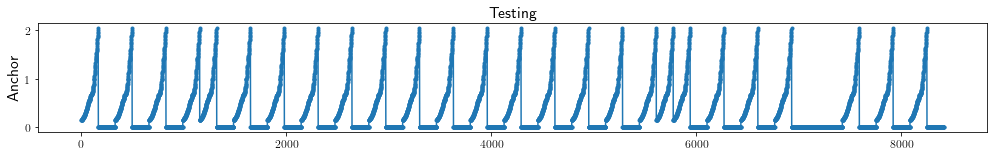

In [6]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_anchor_test.values, '.-')
plt.ylabel("Anchor")
plt.title("Testing");

In [126]:
lambdaSel, mse_df, corr_pearson, mi, lambdasCV = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    deepcopy(dict_models),
    params_climate,
    gamma,
    h_anchors,
    30,
    sel_method="MSE",
    display_CV_plot=True)

In [130]:
lambdaSel

array([ 0.23950266,  5.73615251, 10.82636734, 38.56620421])

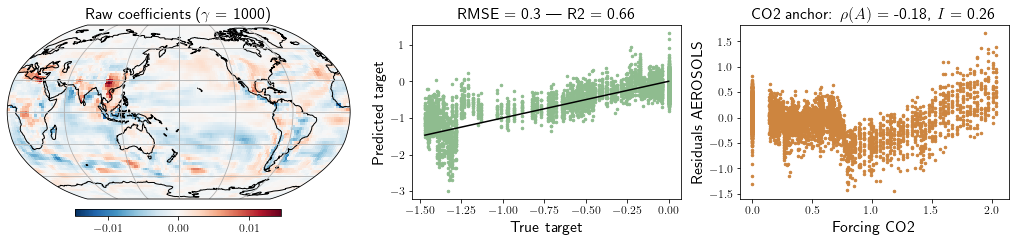

In [128]:
coefRaw, y_test_pred, mse = anchor_regression.anchor_regression_estimator(
    dict_models, gamma, h_anchors, lambdaSel[2])
anchor_regression.make_plots(dict_models, coefRaw, y_test_pred, dict_models["y_anchor_test"],
        gamma, params_climate["target"], params_climate["anchor"], h_anchors)

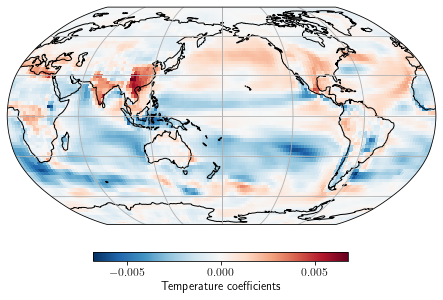

In [88]:
plots.plotMapCartopy(coefRaw.reshape((72,144)), cLim = None)

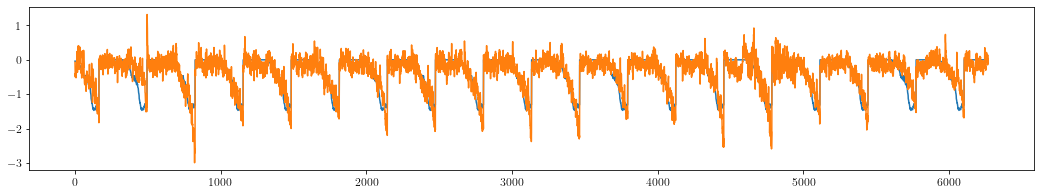

In [131]:
fig = plt.figure(figsize = (18, 3))
plt.plot(y_test.values)
plt.plot(y_test_pred);

In [ ]:
import pickle
filename = ("./../output/data/subagging_" + target + "_" + anchor + "_gamma_" + str(gamma) + "_square_noAhstd.pkl")
with open(filename, 'rb') as f:
    lambdaSel_runs, coefRaw_runs, mse_runs_df, corr_pearson_runs, mi_runs, y_test_pred_runs, \
            ts_null, ts_alt = pickle.load(f)

In [226]:
X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)
sc_X_test = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train.values)
y_train_std = sc_y.fit_transform(y_train.values)
X_test_std = sc_X_test.fit_transform(X_test.values)
y_test_std = sc_y_test.fit_transform(y_test.values)

### Hypothesis testing

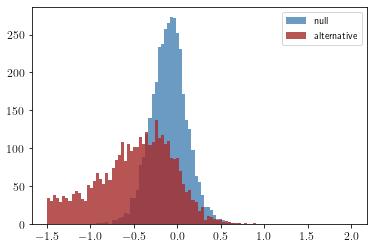

In [89]:
y_null = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] == "piControl":
        y_null = np.concatenate((y_null, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
y_alt = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] != "piControl":
        y_alt = np.concatenate((y_alt, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
bins = np.linspace(-1.5, 2, 100)
plt.hist(y_null, bins, alpha = 0.8, color = "steelblue", label = 'null');
plt.hist(y_alt, bins, alpha = 0.8, color = "brown", label = 'alternative');
plt.legend();

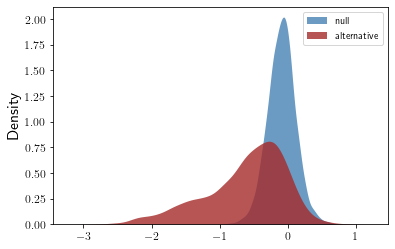

In [90]:
sns.kdeplot(y_null.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "steelblue", label = "null");
sns.kdeplot(y_alt.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "brown", label = "alternative");
plt.legend();

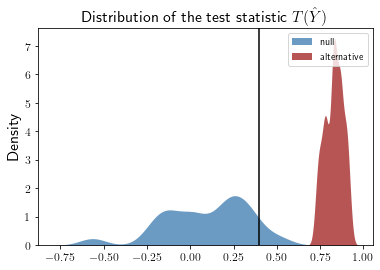

In [92]:
sns.kdeplot(ts_null, bw_method = 0.3, fill = True, color = "steelblue", alpha=.8, linewidth=0, label = "null");
sns.kdeplot(ts_alt, bw_method = 0.3, fill = True, color = "brown", alpha=.8, linewidth=0, label = "alternative");
plt.axvline(np.quantile(ts_null, q = 0.95), 0, 1.4, color = 'k')
plt.xlabel("")
plt.title("Distribution of the test statistic $T(\hat{Y})$")
# plt.yscale("log")
plt.legend();

In [16]:
alpha_bagging, power_bagging, nb_models_bagging, models = hypothesis_testing.test_DA(params_climate, params_anchor)

Bag 0
{'GFD', 'MCM', 'MRI', 'BCC', 'ACC', 'CIE', 'CAS', 'MIR', 'AWI', 'INM', 'SAM', 'KIO', 'NES'}
0 --- ACC --- mean = -0.03210533556440175 --- std = 0.35753055903045916
tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc
historical --- test = 1
tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc
piControl --- test = 0
tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc
historical --- test = 1
tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc
piControl --- test = 0
nb_controls = 2
nb_forced = 2
alpha = 0
power = 2
1 --- AWI --- mean = 0.011377890520292339 --- std = 0.36984672038263877
tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc
historical --- test = 1
tas_ann_AWI-CM-1-1-MR_piControl_r1i1p1f1_g025.nc
piControl --- test = 0
tas_ann_AWI-ESM-1-1-LR_historical_r1i1p1f1_g025.nc
historical --- test = 1
nb_controls = 1
nb_forced = 2
alpha = 0
power = 2
2 --- BCC --- mean = -0.016167313029502042 --- std = 0.38126662020001273
tas_ann_BCC-CSM2-MR_historical_r1i1p1f1_g025.nc
historical --- test = 0
tas_an

In [66]:
import pickle
filename = ("./../output/data/HT_aerosols_co2_gamma_1000.pkl")
with open(filename, 'rb') as f:
    lambdaSel_runs, coefRaw_runs, mse_runs_df, corr_pearson_runs, mi_runs, y_test_pred_runs, alpha_bagging, power_bagging, nb_models_bagging, models = pickle.load(f)

In [67]:
alpha_bagging

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [68]:
power_bagging

array([0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [69]:
nb_models_bagging

array([1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 2., 0., 1., 0.,
       1., 1., 1., 1., 0., 2., 2., 0., 2., 0.])

In [70]:
coefRaw_runs.shape

(2, 10368)

In [13]:
gamma

5000

In [24]:
type(gamma)

int

In [16]:
import yaml
with open("./../params.yml") as file:
        input_params = yaml.full_load(file)

In [17]:
input_params

{'Parameters': '============================================================================= Variables: tas, pr Temporal resolutions: ann, mon, day Grid size at 2.5 degrees: g025 Scenarios CMIP6: historical, hist-GHG, hist-aer, hist-nat, piControl,\n                 ssp119, ssp126, ssp245, ssp370, ssp434, ssp460, ssp585,\n                 (1pctCO2, abrupt-2xCO2, abrupt-4xCO2,\n                 esm-hist, esm-ssp585, esm-1pctCO2, hist-bgc, land-hist,\n                 ssp534-over, ssp534-over-bgc, ssp585-bgc, 1pctCO2-bgc)\nStart date for CMIP6: 1850 Target: 1) forcing (from ERF files): total, total_anthropogenic, GHG, CO2,\n                                     aerosols, total_natural, volcanic, solar\n        2) forced response (computed from the one forcing runs):\n                                     hist-aer, hist-GHG, hist-nat\n=============================================================================\n',
 'temporalRes': 'ann',
 'variables': ['tas'],
 'scenarios': ['historical', 

In [29]:
import argparse
parser = argparse.ArgumentParser()

_StoreAction(option_strings=['--exp'], dest='exp', nargs=None, const=None, default=None, type=None, choices=None, help='The experiment to run', metavar=None)

In [59]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument("--exp", help="The experiment to run")

for arg, val in input_params.items():
    print(arg)
    print(val)
    parser.add_argument(
        "-%s" % arg,
        type=type(val),
        default = val,
    )
    
args, unknown = parser.parse_known_args()
print(args)

Parameters
============================================================================= Variables: tas, pr Temporal resolutions: ann, mon, day Grid size at 2.5 degrees: g025 Scenarios CMIP6: historical, hist-GHG, hist-aer, hist-nat, piControl,
                 ssp119, ssp126, ssp245, ssp370, ssp434, ssp460, ssp585,
                 (1pctCO2, abrupt-2xCO2, abrupt-4xCO2,
                 esm-hist, esm-ssp585, esm-1pctCO2, hist-bgc, land-hist,
                 ssp534-over, ssp534-over-bgc, ssp585-bgc, 1pctCO2-bgc)
Start date for CMIP6: 1850 Target: 1) forcing (from ERF files): total, total_anthropogenic, GHG, CO2,
                                     aerosols, total_natural, volcanic, solar
        2) forced response (computed from the one forcing runs):
                                     hist-aer, hist-GHG, hist-nat

temporalRes
ann
variables
['tas']
scenarios
['historical', 'piControl']
startDate
2000
endDate
2014
target
aerosols
anchor
co2
gamma
[1000]
nonlinear_anchors
[]
Namespace

In [60]:
args, unknown = parser.parse_known_args()
print(args)

Namespace(Parameters='============================================================================= Variables: tas, pr Temporal resolutions: ann, mon, day Grid size at 2.5 degrees: g025 Scenarios CMIP6: historical, hist-GHG, hist-aer, hist-nat, piControl,\n                 ssp119, ssp126, ssp245, ssp370, ssp434, ssp460, ssp585,\n                 (1pctCO2, abrupt-2xCO2, abrupt-4xCO2,\n                 esm-hist, esm-ssp585, esm-1pctCO2, hist-bgc, land-hist,\n                 ssp534-over, ssp534-over-bgc, ssp585-bgc, 1pctCO2-bgc)\nStart date for CMIP6: 1850 Target: 1) forcing (from ERF files): total, total_anthropogenic, GHG, CO2,\n                                     aerosols, total_natural, volcanic, solar\n        2) forced response (computed from the one forcing runs):\n                                     hist-aer, hist-GHG, hist-nat\n=============================================================================\n', anchor='co2', endDate=2014, exp=None, gamma=[1000], nonlinear_anchors

In [58]:
unknown

['-f',
 '/home/eszekely/.local/share/jupyter/runtime/kernel-af28c947-78a9-43f8-93f7-5459fbc0fa6b.json']

In [64]:
type(args.gamma)

list